Code for project 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

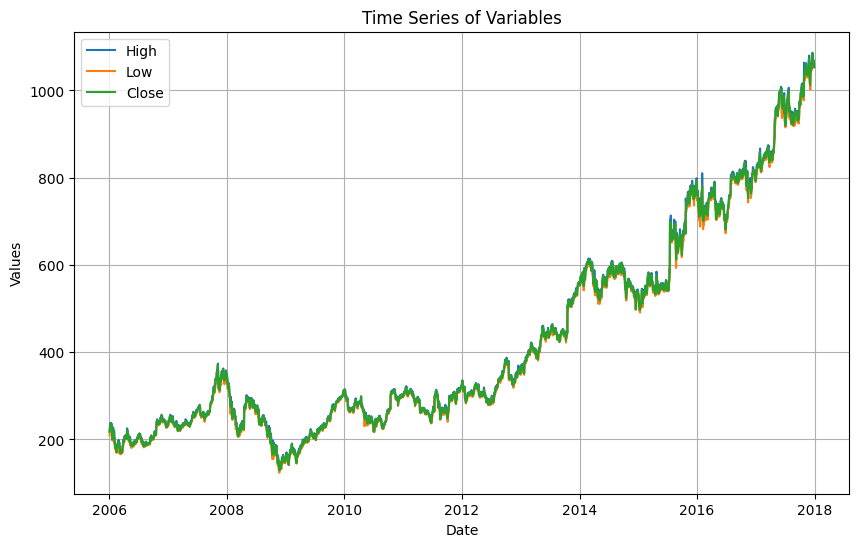

In [ ]:
# Load the CSV file
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])  # Replace 'your_file.csv' with your actual file name and make sure 'Date' is the correct column name

# Set the date as the index (optional, for convenience in plotting)
data.set_index('Date', inplace=True)

# Plot all variables
plt.figure(figsize=(10, 6))
for column in data.columns[1:4]:
    plt.plot(data.index, data[column], label=column)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
# Plot all variables
plt.figure(figsize=(10, 6))
plt.plot(data.index, data[5], label=column)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Index(['High', 'Low', 'Close', 'Volume'], dtype='object')